# Import

In [141]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.callback import Callback


import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
a = np.linspace(1,10,10)
a, np.cumsum(np.hstack([0,a]))

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([ 0.,  1.,  3.,  6., 10., 15., 21., 28., 36., 45., 55.]))

In [149]:
def time_inc_to_time(depth_grid, time_inc, depth, interpolator): 
    # depth_grid, time_inc = depth_time_inc 
    time_discrete = np.cumsum(np.hstack([0, time_inc]))
    time_interpolate = interpolator([depth_grid, time_discrete], depth)
    return time_interpolate
x = np.linspace(0,1,11)
yinc = np.diff(x**2)
c = np.linspace(0,1,100)
yint = time_inc_to_time(x, yinc, c, interpolate_CubicSpline)
%matplotlib inline
plt.figure
plt.plot(c ,yint)
plt.plot(x, np.cumsum(np.hstack([0, yinc])),"." )

# Model

Frequency

In [8]:
b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi

muy_k = muy_k/180/3600*np.pi*1e6
p0 = 50.467718
p0 = p0/180/3600*np.pi*1e6

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
muy_k = muy_k[ordering]
phi_k = phi_k[ordering]


fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
fe_k = fe_k/180/3600*np.pi
fe_k = fe_k*1e6


generate data

In [9]:
np.random.seed(126)
"Generate an age model"
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sine_inverse_SR, A=0.3, k=10)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=2)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
# time_inc = np.diff(time)

"""Generate an data"""

"EP model"
fs = muy_k + p0
phi_true = np.random.rand(len(fs))*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
freqs_true = np.hstack([p0, muy_k])
X_true = generate_X_linReg(np.ones_like(muy_k), fs, time)
y_EP = X_true @ ABtrue
y_model = y_EP

"Noise"

sigma_true = 0.5
rho_true = 0.5

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise
# noise = white_noise

"data"
y = y_model + noise
    
# "simple model"
# f1 = 100; f2= 4.3*100
# A1 = 1; A2 = 1.2
# y_model = A1*np.cos(f1*time) + A2*np.cos(f2*time)
# fs =  np.array([f1, f2])
# y = y_model + noise


Text(0.5, 0, 'depth')

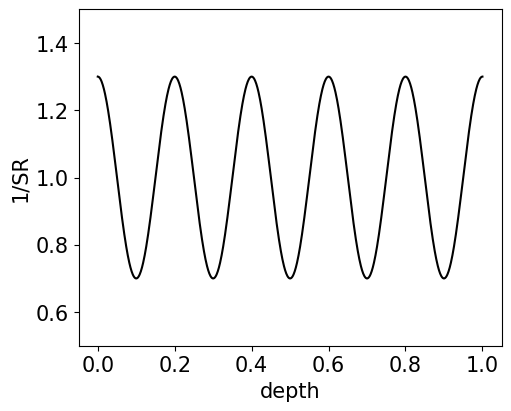

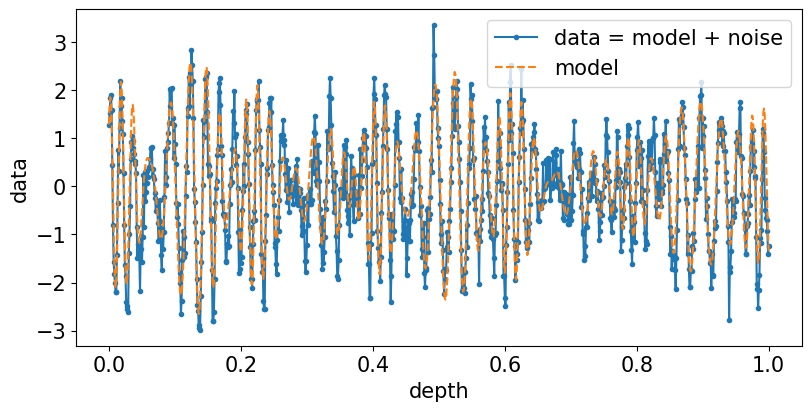

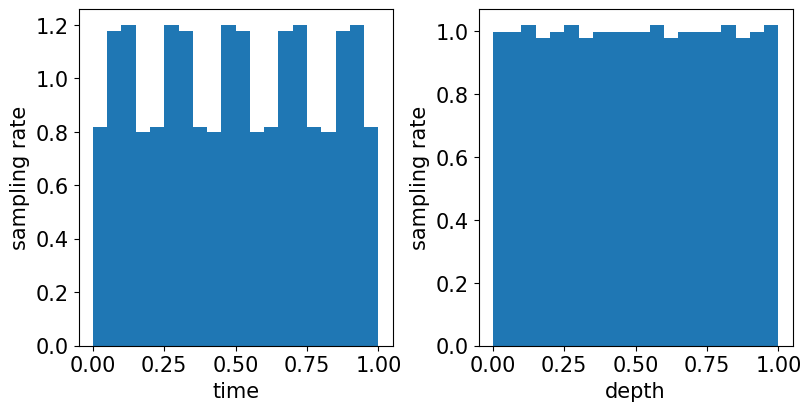

In [10]:
"plot"
# plt.subplots(1,2)
plt.figure(figsize=(5,4), constrained_layout=True)
plt.subplot(1,1,1)
plt.plot(depth, invSR, color="black")
# plt.ylim([0,2])
plt.ylim([0.5,1.5])

plt.xlabel("depth")
plt.ylabel("1/SR")
# plt.subplot(1,2,2)
# plt.xlabel("depth")
# plt.ylabel("time")
# plt.plot(depth, time, color="black")
plt.savefig("figures/invSR_sinek3.png",dpi=200)


plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()
# plt.savefig("figures/data_sinek3.png",dpi=200)
# plt.figure(figsize=(15,4))
# plt.plot(time, y)
# plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
# plt.xlabel("time")
# plt.ylabel("data")

plt.figure(figsize=(8,4), constrained_layout=True)
n = 2
plt.subplot(1,n,1)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,2)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

# GA

In [66]:
def metric_piecewise_td(depth_grid, time_inc, data, fs, interpolator=interpolate_CubicSpline, n_pieces=1, invSR_lims=None, metric_type="r2", *args, **kwargs):
    
    depth, y_data = data
    time_discrete = np.cumsum(np.hstack([0, time_inc]))
    time_interpolate = interpolator([depth_grid, time_discrete], depth)

    X = generate_X_linReg(np.ones_like(fs), fs, time_interpolate)

    reg_model = LinearRegression().fit(X, y_data)
    y_pred = reg_model.predict(X)
    
    depth_pieces = np.linspace(depth[0], depth[-1], n_pieces+1)
    # r2 = np.zeros(n_pieces)
    # RSS = np.zeros(n_pieces)
    metrix = np.zeros(n_pieces)

    for i in range(n_pieces):
        j1, j2 = np.searchsorted(depth, depth_pieces[i],"left"),  np.searchsorted(depth, depth_pieces[i+1], "right")
        if metric_type == "r2":
            metrix[i] = r2_score(y_data[j1:j2], y_pred[j1:j2])
        elif metric_type == "RSS":
            metrix[i] = np.mean((y_data[j1:j2] - y_pred[j1:j2])**2)
        else:
            print("metric type not defined")
    return metrix

def timeinc_to_pred(depth_grid, time_inc, data, fs, interpolator=interpolate_CubicSpline):
    depth, y = data
    time = time_inc_to_time(depth_grid, time_inc, depth, interpolator)
    X = generate_X_linReg(np.ones_like(fs), fs, time)
    reg_model = LinearRegression().fit(X, y)
    y_pred = reg_model.predict(X)
    return time, y_pred

def invSR_to_pred(depth_invSR, data, invSR_lims, fs, interpolator=interpolate_CubicSpline):
    depth, y = data
    invSR_interpolate = interpolator(depth_invSR, depth)
    invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
    invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
    X = generate_X_linReg(np.ones_like(fs), fs, time)
    reg_model = LinearRegression().fit(X, y)
    y_pred = reg_model.predict(X)
    return time, y_pred


In [12]:
class TDinference(ElementwiseProblem):

    def __init__(self, depth_genes, genes_lims, interpolator, data, fs, n_pieces=1, metric=metric_piecewise_td):

        self.time_inc = genes_lims
        self.depth_genes = depth_genes 
        self.interpolator = interpolator
        self.data = data
        self.fs = fs

        N_genes = len(depth_genes)-1
        xl = np.zeros(N_genes) + genes_lims[0]
        xu = np.zeros(N_genes) + genes_lims[1]
        self.func_metric = partial(metric, data=data, fs=fs, interpolator=interpolator, n_pieces=n_pieces)
        super().__init__(n_var=N_genes, n_obj=n_pieces, xl=xl, xu=xu)

    def _evaluate(self, genes, out, *args, **kwargs):
        # print(genes)
        out["F"] = -self.func_metric(self.depth_genes, genes)


array([0.11122659, 0.19786592])

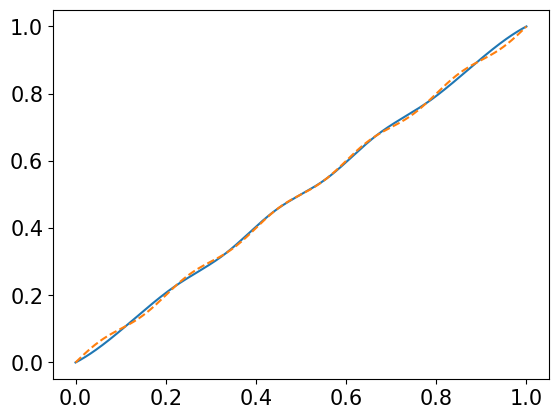

In [13]:
N_population = 128 # number of individual in population 
N_generations_max = 100
N_genes = 10
depth_genes = np.linspace(0,1,N_genes)
true_genes = np.diff(interpolate_CubicSpline([depth, time], depth_genes))
true_genes
plt.plot(depth, time_inc_to_time(depth_genes, true_genes, depth, interpolate_CubicSpline))
plt.plot(depth, time, "--")
# plt.plot(depth, time-time_inc_to_time(depth_genes, true_genes, depth, interpolate_CubicSpline))
metric_piecewise_td(depth_genes, true_genes, [depth, y], fs, interpolator=interpolate_CubicSpline, n_pieces=2)


In [14]:
N_population = 128 # number of individual in population 
N_generations_max = 100
N_genes = 20 # number of intial gene in an individial of the population 
depth_genes = np.linspace(0,1,N_genes+1)
true_genes = np.diff(interpolate_CubicSpline([depth, time], depth_genes))
# timeinc_lims = [0, 1/(N_genes)*10]
timeinc_lims = [0, 1]
metric_piecewise_td(depth_genes, true_genes, [depth, y], fs, interpolator=interpolate_CubicSpline, n_pieces=1)
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise_td(depth_genes, true_genes, [depth, y], fs, interpolator=interpolate_CubicSpline, n_pieces=2)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = TDinference(depth_genes, timeinc_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise_td)
out = {}
problem._evaluate(true_genes, out)
out

[0.8381664  0.79666438]


{'F': array([-0.8381664 , -0.79666438])}

In [123]:
algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 2000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# X = res.X
# F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     10 |             - |             -
     2 |      300 |     13 |  0.1067987449 |         ideal
     3 |      400 |     10 |  0.0469083905 |             f
     4 |      500 |     10 |  0.1978222296 |         ideal
     5 |      600 |     11 |  0.0173302922 |             f
     6 |      700 |     12 |  0.1273056475 |         ideal
     7 |      800 |      9 |  0.0235345089 |         ideal
     8 |      900 |      7 |  0.0189196739 |         ideal
     9 |     1000 |      6 |  0.0158429545 |         ideal
    10 |     1100 |      5 |  0.0131904926 |             f
    11 |     1200 |      8 |  0.0480736802 |             f
    12 |     1300 |     10 |  0.1642522596 |         ideal
    13 |     1400 |     11 |  0.0230533366 |             f
    14 |     1500 |     11 |  0.0334034817 |         ideal
    15 |     1600 |     11 |  0.0032083838 |             f
    16 |     1700 |      8 |  0.0509852703 |         ide

KeyboardInterrupt: 

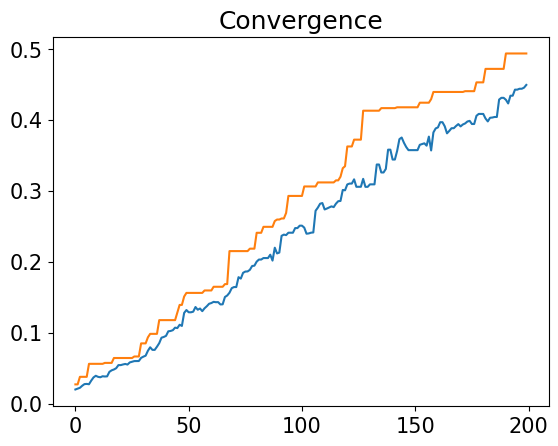

In [122]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure()
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.yscale("log")
plt.show()

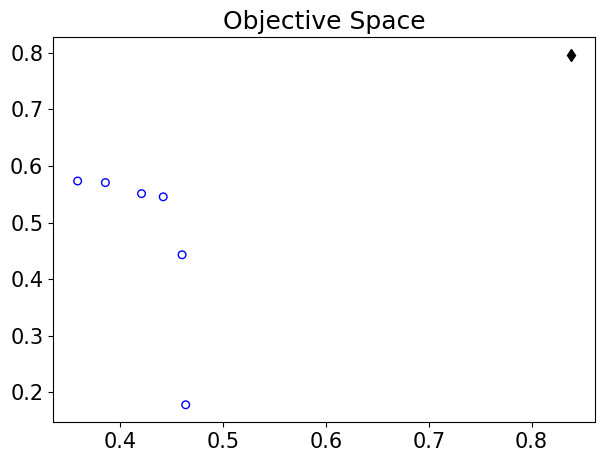

In [124]:
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


In [138]:
i = 4
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]

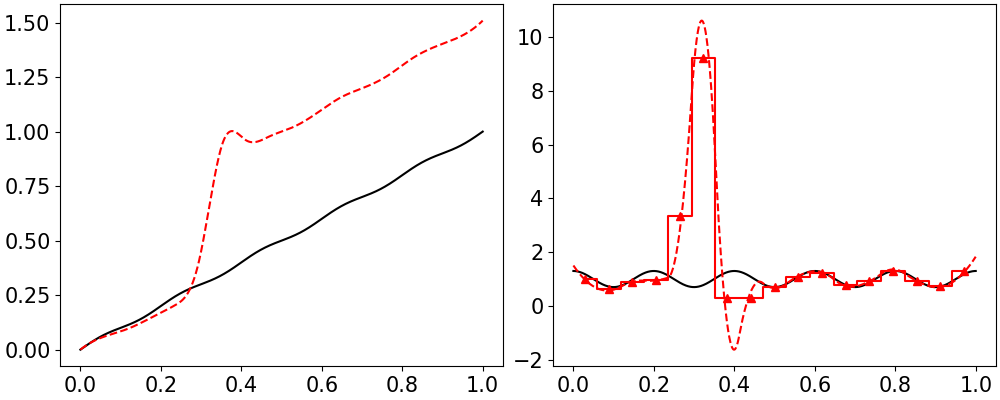

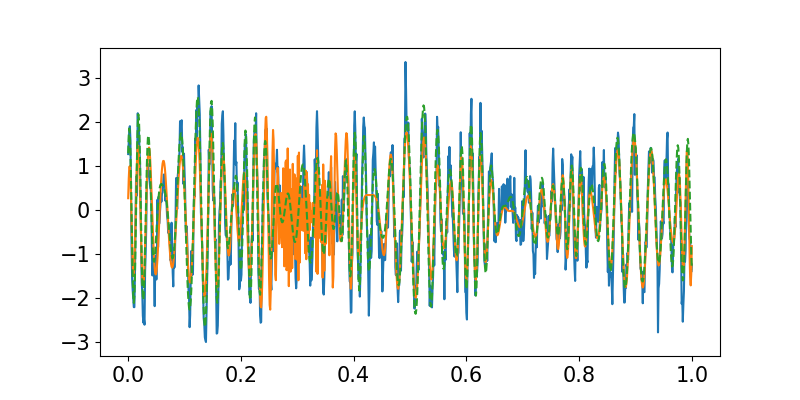

In [140]:
%matplotlib widget
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
# invSR_best = res.X[arg_best]

plt.figure(constrained_layout=True,figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(depth, time, color="black")
# for i in range(res.F.shape[0]):
#     plt.plot(depth, time_inc_to_time(depth_genes, res.X[i], depth, interpolate_CubicSpline), "--", color="black")
    # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    # plt.plot(depth, invSR_interpolate, alpha=0.2)
time_pred = time_inc_to_time(depth_genes,  res.X[arg_best], depth, interpolate_CubicSpline)
plt.plot(depth, time_pred, "r--")
plt.subplot(1,2,2)
dd = depth[1]-depth[0]
plt.plot(depth[:-1]+dd/2, np.diff(time)/dd, '-', color="black")
plt.plot(depth[:-1]+dd/2, np.diff(time_pred)/dd, '--', color="red")

dd = depth_genes[1]-depth_genes[0]
plt.step(depth_genes[:-1]+dd/2, res.X[arg_best]/dd, 'r^-', where="mid")
# plt.plot(depth_genes[:-1]+dd/2, res.X[arg_best]/dd, '.', color="black")
# for i in range(res.F.shape[0]):
#     plt.plot(depth_genes[:-1], res.X[i], '.', color="black")
# for i in range(res.F.shape[0]):
#     plt.plot(depth_genes[:-1]+dd/2, res.X[i]/dd, '.', color="black")

plt.figure(figsize=(8,4))
time_pred, ypred= timeinc_to_pred(depth_genes, res.X[arg_best], data, fs, interpolate_CubicSpline)
plt.plot(depth, y)
plt.plot(depth, ypred)
plt.plot(depth, y_model, "--")



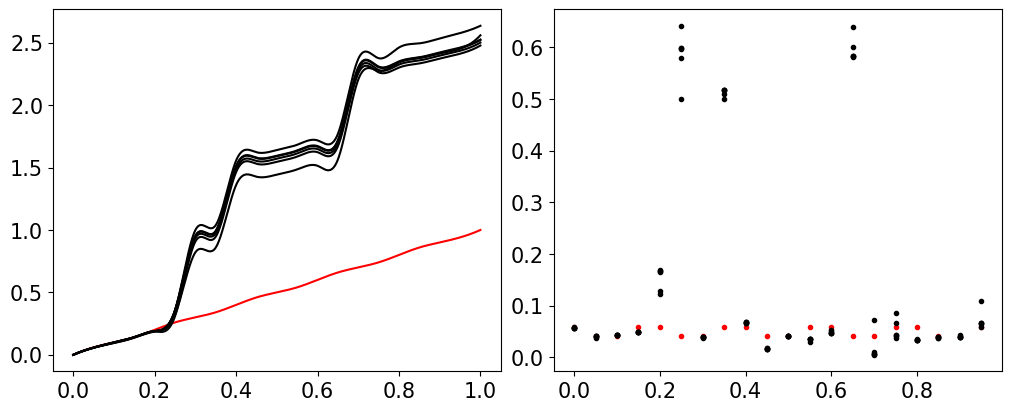

In [127]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

plt.figure(constrained_layout=True,figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(depth, time_inc_to_time(depth_genes, true_genes, depth, interpolate_CubicSpline), color="red")
for i in range(res.F.shape[0]):
    plt.plot(depth, time_inc_to_time(depth_genes, res.X[i], depth, interpolate_CubicSpline), color="black")
    # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    # plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.subplot(1,2,2)
plt.plot(depth_genes[:-1], true_genes, '.', color="red")
for i in range(res.F.shape[0]):
    plt.plot(depth_genes[:-1], res.X[i], '.', color="black")


# plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

# Analysis of number of genes

In [18]:
class Callback_getF(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []

    def notify(self, algorithm):
        b = algorithm.pop.get("F").mean(axis=1).min()
        self.data["best"].append(b)

In [25]:
algorithm = NSGA2(
    pop_size=400,
    n_offsprings=200,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 2000
termination = get_termination("n_gen", N_generations)
N_genes_enemble = np.arange(2, 50, 4)
depth_genes_ensemble = [np.linspace(0,1,N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)

problems = [TDinference(depth_genes, timeinc_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise_td) for depth_genes in depth_genes_ensemble  ] 


# res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, save_history=True) for problem in problems)
res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, save_history=False, callback=Callback_getF())
                                                        for problem in problems)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed: 14.6min remaining: 73.1min
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed: 14.8min remaining: 44.3min
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed: 14.8min remaining: 29.5min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed: 14.8min remaining: 20.7min
[Parallel(n_jobs=12)]: Done   6 out of  12 | elapsed: 14.8min remaining: 14.8min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed: 14.9min remaining: 10.7min
[Parallel(n_jobs=12)]: Done   8 out of  12 | elapsed: 15.0min remaining:  7.5min
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed: 15.0min remaining:  5.0min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed: 15.0min remaining:  3.0min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed: 15.1min remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapse

C:\Users\hhnam\AppData\Local\Temp\ipykernel_14748\2489391538.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0, 0.5, 'r2')

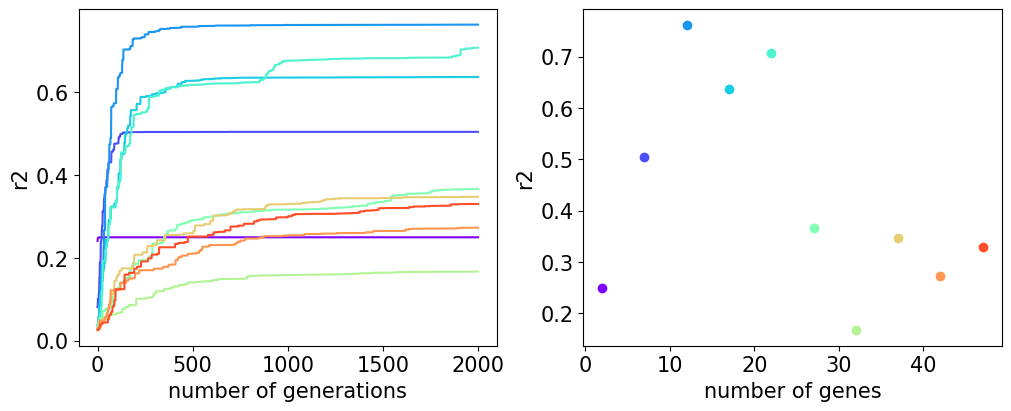

In [23]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.47])
# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
[plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(i/N_ensemble)) for i in range(N_ensemble)]
plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.47])
# plt.savefig("r2_Ngenesb.png", dpi=200)

C:\Users\hhnam\AppData\Local\Temp\ipykernel_14748\2489391538.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0, 0.5, 'r2')

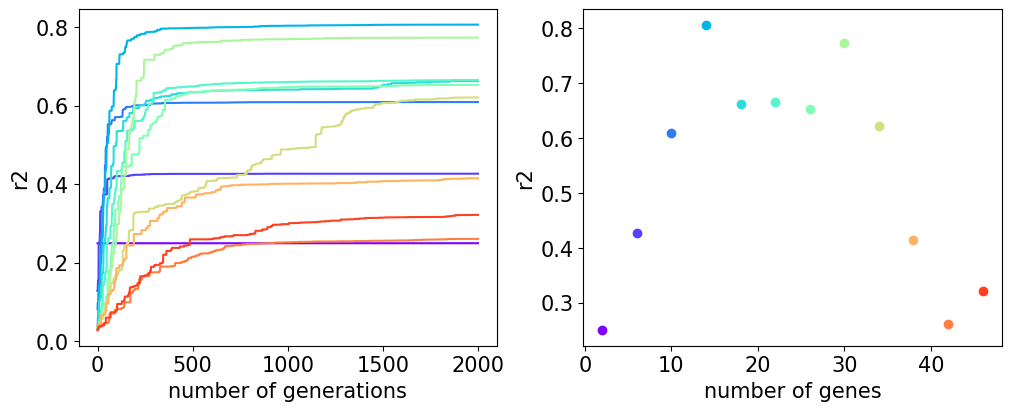

In [26]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.47])
# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
[plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(i/N_ensemble)) for i in range(N_ensemble)]
plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.47])
# plt.savefig("r2_Ngenesb.png", dpi=200)

In [84]:
res.X.shape

(400, 1)

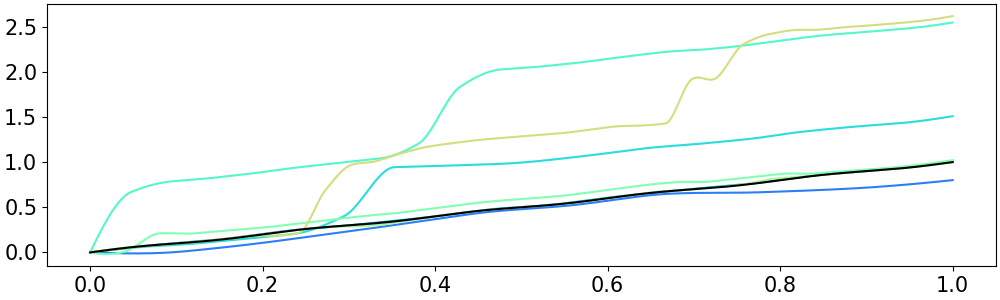

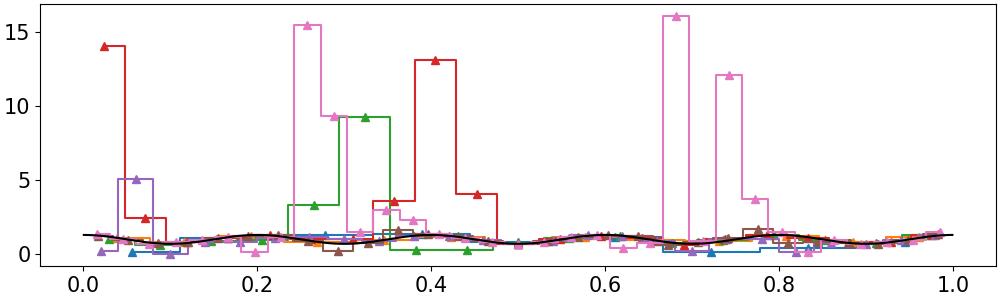

In [129]:
%matplotlib widget

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    if i < 2 or i >= 9 :
        continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    # ax.plot(depth, res.X, color=cmap(i/N_ensemble))
    # ax.plot(depth_genes[:-1], res.X[arg_best], '.', color=cmap(i/N_ensemble))
    ax.plot(depth, time_inc_to_time(depth_genes, res.X[arg_best], depth, interpolate_Akima), color=cmap(i/N_ensemble))
# ax.set_ylim([-0.1,1.1])
ax.plot(depth, time, color="black")

# time_inc_to_time(depth_genes, true_genes, depth, interpolate_CubicSpline)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
for i, res in enumerate(res_ensemble):
    if i < 2 or i >= 9 :
        continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    dd = depth_genes[1]-depth_genes[0]
    # plt.plot(depth_genes[:-1]+dd/2, res.X[arg_best]/dd, '.', color=cmap(i/N_ensemble))
    plt.step(depth_genes[:-1]+dd/2, res.X[arg_best]/dd, '^-', where="mid")


dd = depth[1]-depth[0]
plt.plot(depth[:-1]+dd/2, np.diff(time)/dd, '-', color="black")
# fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# plt.ylim(0,2)
# time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
# ax.plot(depth, y )
# ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")